# Sentiment Analysis

## Logistic Regression Classifier
- 1. Obtain features from text.
- 2. Train model while minimizing cost function.
- 3. Predict and evaluate.

### 1. Features extraction - Represent text into vectors:

#### **Option 1**: Create a Vocabulary. 1 if the word exists, 0 if not -> Leads to Sparse matrix.
- - Un vocabulario contiente todas las palabras (de forma unica) que aparecen en los tweets. 
- - Para representar nuevos tweet con numeros:
- - - Ponemos un 1, por cada palabra que aparece en el vocabulario.
- - - Ponemos un 0, por cada palabra inexistente en el vocabulario.
-
- Ejemplo:
I am happy because I am learning NLP.
I love comedy movies.
VOCABULARIO:
V = [ I, am, happy, because, learning, NLP, love, comedy, movies ]
-
-
- Nuevo tweet:
I am also learning german.
- Representacion del nuevo tweet en base al Vocabulario:
- Vocab = [ I, am, happy, because, learning, NLP, love, comedy, movies ]
- tweet = [ 1,  1,     0,       0,        1,    0,   0,      0,      0 ].
- Length tweet = Length Vocabulary.
-
- Cada tweet, tendrá un tamaño igual a la longitud del vocabulario.
- Entonces, la logistic regression function tendrá que predecir len(V) + 1 (b0) parametros. 
- Every x = [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...]
- Label y = 1 if Positive, 0 if negative.
- Sparse problem + entrenamiento caro y lento.
-
#### **Option 2**: Positive and Negative Frequencies sum as features:
- Let's count how many times each word appears in a positive and negative tweet. Sum those counts.

![Alt text1](../figures/sentiment_analysis_logistic.png)
-
- Define each tweet as:
- [ Bias, Sum Pos. Freq, Sum Neg. Freq. ]
- Example: I am happy, I am learning NLP.
- [ 1, 10, 8 ]

## 2. Preprocessing for Sentiment Analysis

In [183]:
import nltk                                # Python library for NLP with tweet data set.
from nltk.corpus import twitter_samples    # sample Twitter dataset from NLTK
import matplotlib.pyplot as plt            # library for visualization
import random                              # pseudo-random number generator
import pandas as pd

#### Data set - NLKT
- The NLKT data set contains 5000 positive tweets and 5000 negative tweets.
- In a real-world example the data set is most probably not balanced.
- I'ĺl cover text and image imbalanced data sets in another notebook.

In [3]:
# downloads sample twitter dataset.
nltk.download('twitter_samples')

[nltk_data] Downloading package twitter_samples to
[nltk_data]     /home/mark/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.


In [15]:
raw_positive_tweets = twitter_samples.strings('positive_tweets.json')
raw_negative_tweets = twitter_samples.strings('negative_tweets.json')

print('Number of positive tweets: ', len(raw_positive_tweets))
print('Number of negative tweets: ', len(raw_negative_tweets))

print('\nThe type of all_positive_tweets is: ', type(raw_positive_tweets))
print('The type of a tweet entry is: ', type(raw_negative_tweets[0]))

Number of positive tweets:  5000
Number of negative tweets:  5000

The type of all_positive_tweets is:  <class 'list'>
The type of a tweet entry is:  <class 'str'>


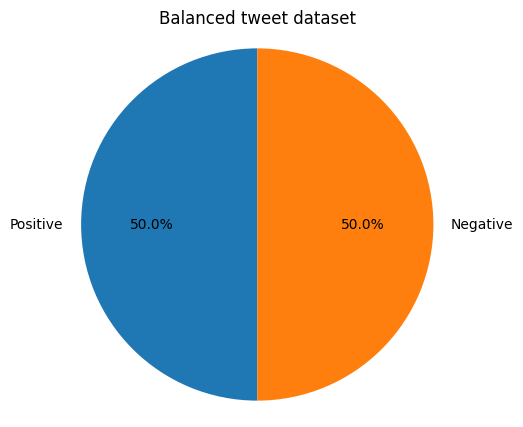

In [23]:
## Let's show the balance of the data set with a Pie Chart:
fig = plt.figure(figsize=(5, 5))

# Lables of the classes:
labels = 'Positive', 'Negative'

# Size of each label
number_of_tweets = [
    len(raw_positive_tweets), len(raw_negative_tweets)
]

# Pie-chart where the slices are ordered and plotted counter-clockwise:
plt.pie(x = number_of_tweets,
        labels = labels,
        autopct='%1.1f%%',
        shadow=False,
        startangle=90)

# Set title
plt.title("Balanced tweet dataset")

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

# Display the chart
plt.show()

In [35]:
## By displaying the raw data, we can observe links, emojis and some explicit content...
print(
    "Raw Positive Tweet:\n\033[92m"+f"{raw_positive_tweets[random.randint(0,5000)]}\n"
)

print(
    "\033[0mRaw Negative Tweet:\n\033[91m"+f"{raw_positive_tweets[random.randint(0,5000)]}"
)

Raw Positive Tweet:
Friend's lunch... yummmm :)
#Nostalgia #TBS #KU.

Raw Negative Tweet:
I slept less that 7 hours last night, preparing myself for possible naps :p


### Step 1. Cleaning. Stop-words, links, formats, styles ...

In [36]:
# download the stopwords from NLTK
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/mark/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [37]:
import re                                  # library for regular expression operations
import string                              # for string operations

In [129]:
def preprocess_tweet(raw_tweet, tokenizer, stopwords, stemmer):
    """
    Clean the tweet from stop-words, hyperlinks, formats, styles and any non-informative character.
    
    Input:
        raw_tweet : string
            Current raw tweet as a string.
    Output:
        stems_cleaned_tweet : string
            Stems from current cleaned tweet.

    """

    # Step 1. Remove Old Twitter format and style:
    raw_tweet = re.sub( pattern=r'^RT[\s]',       # Expression to substitute by repl.
                        repl='',                  # Replicate with nothing.
                        string=raw_tweet)         # String to be checked.

    # Step 2. Remove hyperlinks:
    raw_tweet = re.sub( pattern=r'https?:\/\/.*[\r\n]*',
                        repl='',
                        string=raw_tweet)
    
    # Step 3. Remove Hastags
    raw_tweet = re.sub( pattern=r'#.*?(?=\s)',
                            repl='',
                            string=raw_tweet)
    
    # Step 4. Remove @tags:
    cleaned_tweet = re.sub( pattern=r'@.*?(?=\s)',
                            repl='',
                            string=raw_tweet)
    
    # Step 5. All to lowercase + remove duplicates!
    
    # Tokenize cleaned tweet into words.
    tokens_cleaned_tweet = tokenizer.tokenize(cleaned_tweet)

    # From all the tokens (words), remove the ones that are stopwords or punctuation
    cleaned_tokens_cleaned_tweet = [word for word in tokens_cleaned_tweet if word not in stopwords and word not in string.punctuation]

    # Stem the tokens (words)
    stems_cleaned_tweet = [stemmer.stem(stem) for stem in cleaned_tokens_cleaned_tweet]

    return stems_cleaned_tweet

In [79]:
## Preprocessing
from nltk.tokenize import TweetTokenizer   # module for tokenizing strings

# Instantiate tokenizer class
tokenizer = TweetTokenizer(preserve_case=False,    strip_handles=True, reduce_len=True)

# Find stopwords list and punctuaction string to clean the tokens:
from nltk.corpus import stopwords
import string

stopwords_ = stopwords.words("english")
print(
    f"Using module nltk.corpus.stopwords. Ex: {stopwords_[0:6]}\n"
)
print(
    f"Using module strings: Ex: {string.punctuation}\n"
)

# Initiate class to get stems from words:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

# Run Preprocessing Example:
raw_tweet_example = raw_positive_tweets[775]
print(
    f"Tweet example:\n\033[92m{raw_tweet_example}\n"
)

print("\033[0mOutput stems from cleaned tweet:")
print(preprocess_tweet(raw_tweet_example, tokenizer, stopwords_, stemmer))



Using module nltk.corpus.stopwords. Ex: ['i', 'me', 'my', 'myself', 'we', 'our']

Using module strings: Ex: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~

Tweet example:
Hi #Gorgeous @TillieModel have  a nice swim with your sis!! Can I get a #Birthday shout out please it would make my day?? #Perfection :) xx

Output stems from cleaned tweet:
Hi have  a nice swim with your sis!! Can I get a shout out please it would make my day?? :) xx
['hi', 'nice', 'swim', 'si', 'get', 'shout', 'pleas', 'would', 'make', 'day', ':)', 'xx']


- We can see the cleaned stems from the tweet. As well as some problems with repetitive punctuation.

## Sentiment Frequencies and its visualization.

#### GOAL
- 1. From a list of raw tweets, we want to pre-process each of them to get their stems.
- 2. We need to label them with Positive or Negative following the supervised data set.
- 3. We need to count the number of appearances of each stem in the whole tweet data set.

In [130]:
# 1 # 
import numpy as np

def get_stems_frequencies(raw_tweets, sentiment_labels):
    """
    Build the sentiment frequencies. Count the number of appearances of each stem in the whole tweet data set.

    Input
        raw_tweets : list
            List of raw tweets.
        sentiment_labels : list
            List of binary label {0, 1}. 0 - Negative. 1 - Positive.
    Output:
        stem_frequencies : dict
            Dictionary containing as key the stem and label, and the frequency as value.
    
    """

    # Make sure sentiment_labels is a list. (useful for zip function)
    if isinstance(sentiment_labels, np.ndarray):
        sentiment_labels = np.squeeze(sentiment_labels).tolist()
    
    # Populate the stem_dictionary:
    stem_dictionary = {}
    for y, raw_tweet in zip(sentiment_labels, raw_tweets):                          # For each raw tweet.
        cleaned_stems_tweet = preprocess_tweet(raw_tweet=raw_tweet,                 # Get its cleaned stems.
                                         tokenizer=tokenizer,
                                         stopwords=stopwords_,
                                         stemmer=stemmer)
        for stem in cleaned_stems_tweet:                                            # For each stem.
            stem_dictionary[(stem, y)] = stem_dictionary.get((stem, y), 0) + 1      # Check if its in dictionary and + 1.
                                                                                    # or create a new key (stem, label) = 1.


    return stem_dictionary



In [110]:
# GET ALL RAW TWEETS
raw_tweets = raw_positive_tweets + raw_negative_tweets

# SET PROPER LABELS

sentiment_labels = np.append(
    np.ones((
        len(raw_positive_tweets)
        )
    ),
    np.zeros((
        len(raw_negative_tweets)
        )
    )
).tolist()

print("Labels: ",type(sentiment_labels))
print(sentiment_labels[0], sentiment_labels[-1])

Labels:  <class 'list'>
1.0 0.0


In [131]:
# BUILD FREQUENCIES
stems_freq = get_stems_frequencies(raw_tweets=raw_tweets,
                                   sentiment_labels=sentiment_labels)

In [132]:
for stem_freq in list(stems_freq.items())[0:3]:
    print(
        f"{stem_freq}\nStem: {stem_freq[0][0]}\nSentiment:{stem_freq[0][1]}\nAppearances: {stem_freq[1]}\n"
    )
    

(('top', 1.0), 32)
Stem: top
Sentiment:1.0
Appearances: 32

(('engag', 1.0), 7)
Stem: engag
Sentiment:1.0
Appearances: 7

(('member', 1.0), 16)
Stem: member
Sentiment:1.0
Appearances: 16



## Visualize the words sentiment frequencies

In [140]:
# Assuming each stem is unique, which we have not checked!
keys = ['happi', 'merri', 'nice', 'good', 'bad', 'sad', 'mad', 'best', 'pretti',
        '❤', ':)', ':(', '😒', '😬', '😄', '😍', '♛',
        'song', 'idea', 'power', 'play', 'magnific', 'new', 'friday', 'age']

# Create a LIST [<stem>, <positive_count>, <negative_count>]
stems_features = []

# For each stem:
for word in keys:
    
    # Let's count the number of time that they appear as positive (label = 1) or negative (label = 0)
    pos = 0
    neg = 0
    
    # Retrieve number of positive counts
    if (word, 1) in stems_freq:
        pos = stems_freq[(word, 1)]
        
    # Retrieve number of negative counts
    if (word, 0) in stems_freq:
        neg = stems_freq[(word, 0)]
        
    # Append the stem counts to the table
    stems_features.append([word, pos, neg])
    
stems_features

[['happi', 204, 25],
 ['merri', 1, 0],
 ['nice', 98, 19],
 ['good', 238, 101],
 ['bad', 18, 68],
 ['sad', 5, 121],
 ['mad', 2, 11],
 ['best', 65, 22],
 ['pretti', 19, 15],
 ['❤', 29, 21],
 [':)', 3567, 2],
 [':(', 1, 4571],
 ['😒', 1, 3],
 ['😬', 0, 2],
 ['😄', 5, 1],
 ['😍', 2, 1],
 ['♛', 0, 210],
 ['song', 21, 27],
 ['idea', 26, 10],
 ['power', 7, 6],
 ['play', 46, 48],
 ['magnific', 1, 0],
 ['new', 143, 51],
 ['friday', 104, 12],
 ['age', 2, 8]]

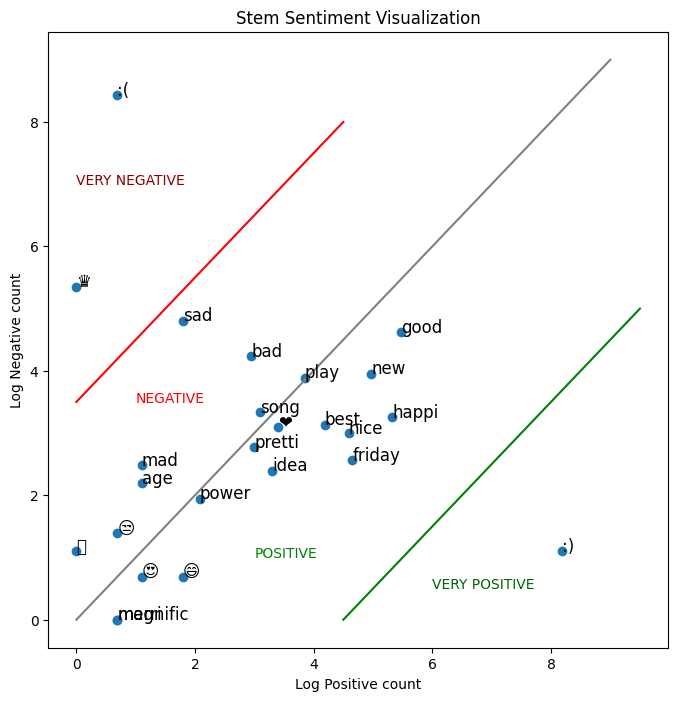

In [169]:
fig, ax = plt.subplots(figsize = (8, 8))

# Convert positive raw counts to logarithmic scale. we add 1 to avoid log(0)
x = np.log([x[1] + 1 for x in stems_features])  

# Do the same for the negative counts
y = np.log([x[2] + 1 for x in stems_features]) 

# Plot a dot for each pair of stems
ax.scatter(x, y)  

# Assign axis labels
plt.title("Stem Sentiment Visualization")
plt.xlabel("Log Positive count")
plt.ylabel("Log Negative count")

# Add the stem as the label at the same position as you added the points just before
for i in range(0, len(stems_features)):
    ax.annotate(stems_features[i][0], (x[i], y[i]), fontsize=12)

ax.plot([0, 9], [0, 9], color = 'gray') # Plot the gray line that divides the 2 areas.
ax.plot([4.5, 9.5], [0,5], color = 'green') # Plot the green line that finds very positive stems.
ax.plot([0, 4.5], [3.5, 8], color = 'red') # Plot the red line that finds very negative stems.

ax.text(0, 7, "VERY NEGATIVE", color = "darkred")
ax.text(1,3.5, "NEGATIVE", color = "red")
ax.text(6, 0.5, "VERY POSITIVE",  color = "darkgreen")
ax.text(3, 1, "POSITIVE",  color = "green")

plt.show()

## LOGISTIC REGRESSION

#### The function of a logistic regression is a Sigmoid function.
- It depends on the parameters Theta and the features vector X_i.
- i -> ith observation or data point.
- It approaches 0, as the dot product (Theta.T, X_i) approaches -INF.
- It approaches 1, if the same dot product approaches +INF.
- For classification we need a Threshold. (Red line). 
- It default to the dot product (Theta.T, X_i) = 0.
- - If dot product (Theta.T, X_i) > 0, the prediction is POSITIVE.
- - If dot product (Theta.T, X_i) < 0, the prediction is NEGATIVE.

![Alt text](../figures/logisticR.png)

#### After pre-processing the text and obtaining the features ( sentiment frequencies ):
- 1. ADD A BIAS TERM = 1. 
- 2. INITIALIZE PARAMETER THETA. 
- 3. PREDICT.
- 4. CHECK COST FUNCTION.
- 5. UPGRADE PARAMETERS.
- 6. ITERATE UNTIL THETA MINIMIZES COST FUNCTION.

![Alt text](../figures/logistic_pred.png)

In [237]:
## ADD BIAS TO STEM FREQUENCIES

def add_bias_to_stem_frequencies(stems_freq, sentiment_labels, bias):
    """
    Add bias to stem frequencies.
    Input:
        stem_freq : dict
            stem frequencies. Keys = (stem, label); Value = appearances.
        bias : int
            bias term.
    Output:
        stems_features : list
            List of stems features with the bias term added.   
    
    """
    
    # Get all stems (stem, label)
    stems = [stem[0] for stem in list(stems_freq.keys())]

    # Create a LIST [<stem>, <bias>, <positive_count>, <negative_count>]
    stems_features_with_bias = []

    # For each stem:
    for word, sentiment in zip(stems, sentiment_labels):
        
        # Let's count the number of time that they appear as positive (label = 1) or negative (label = 0)
        pos = 0
        neg = 0
        
        # Retrieve number of positive counts
        if (word, 1) in stems_freq:
            pos = stems_freq[(word, 1)]

        # Retrieve number of negative counts
        if (word, 0) in stems_freq:
            neg = stems_freq[(word, 0)]

        # Append the stem counts to the table
        stems_features_with_bias.append([word, bias, pos, neg])

    # ADD THE SENTIMENT
    for stem_bias in stems_features_with_bias:
        stem_bias.append(0) if stem_bias[2] < stem_bias[3] else stem_bias.append(1)

    return stems_features_with_bias

In [238]:
stems_features_with_bias = add_bias_to_stem_frequencies(stems_freq=stems_freq,
                                                        sentiment_labels=sentiment_labels,
                                                        bias=1)

In [239]:
dataframe = pd.DataFrame(stems_features_with_bias, columns=["Stem", "Bias", "Positive", "Negative", "Sentiment"])
dataframe = dataframe.sort_values(by="Positive", ascending=False)
dataframe = dataframe.drop_duplicates(keep="last")
dataframe.head(10)

,Stem,Bias,Positive,Negative,Sentiment
9301,:),1,3567,2,1
113,:-),1,692,0,1
70,:d,1,629,0,1
18,thank,1,620,107,1
45,love,1,397,151,1
6333,follow,1,377,262,1
6208,...,1,285,330,0
6198,day,1,245,149,1
6179,good,1,238,101,1
43,like,1,232,223,1


In [241]:
# Each feature is labeled as bias, positive and negative
X = np.asarray(dataframe[['Bias', 'Positive', 'Negative']].values) # Get only the numerical values of the dataframe
Y = np.asarray(dataframe['Sentiment'].values) # Store in Y the corresponding labels or sentiments

print(X.shape) # Print the shape of the X part
print(X) # Print some rows of X

(8062, 3)
[[   1 3567    2]
 [   1  692    0]
 [   1  629    0]
 ...
 [   1    0    1]
 [   1    0    1]
 [   1    0    3]]


In [244]:
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (6449, 3) (6449,)
Test set: (1613, 3) (1613,)


### Find Theta
- If Theta consisted only of 2 values we could visualize it with an X-Y graph.
- 1. Randomly initialize theta at iteration 0 -> (more external green point.)
- - We can check in the right-plot, that at iteration 0, our cost function value is very high.
-
- 2. Upgrade theta in the direction of the gradient of our Cost Function.
- - - Theta = Theta - step alpha * Gradient (Cost Function)
- - By using the Gradient Descent, we can step into the global minimum of the cost function.
- - At that point, Theta would consist of the values that have minimized the cost function, therefore:
- - y_predicted and y_observed are very similar since the cost function value is very low.

![Alt text](../figures/theta.png)

In [247]:
from sklearn.linear_model import LogisticRegression


# Set regularization rate
reg = 0.01

# train a logistic regression model on the training set
model = LogisticRegression(C=1/reg, solver="liblinear").fit(X_train, y_train)
print(
    f"Theta = {model.coef_}"
)


Theta = [[   0.          153.24980808 -181.89950924]]


## Validation

- We'll need the Test data set, X and Y, and Theta.
- 1. Calculate sigmoid function with X_validation and Theta.
- 2. Set a threshold. Ex: 0.5.
- 3. If the result is higher than the threshold, classify as positive, label 1. Else, 0.


In [276]:
from sklearn.metrics import accuracy_score

predictions = model.predict(X_test)
print('Predicted labels: ', predictions)
print('Actual labels:    ' ,y_test)
print('Accuracy: ', accuracy_score(y_test, predictions))
print(
    f"\nOut of {len(predictions)} tweets,\nwe were able to correctly classify {np.sum(y_test == predictions)}."
)

Predicted labels:  [1 1 1 ... 1 0 0]
Actual labels:     [1 1 1 ... 1 0 0]
Accuracy:  0.9993800371977681

Out of 1613 tweets,
we were able to correctly classify 1612.


## Ensure that the features that we chose to represent text make sense:

(0.0, 15.0)

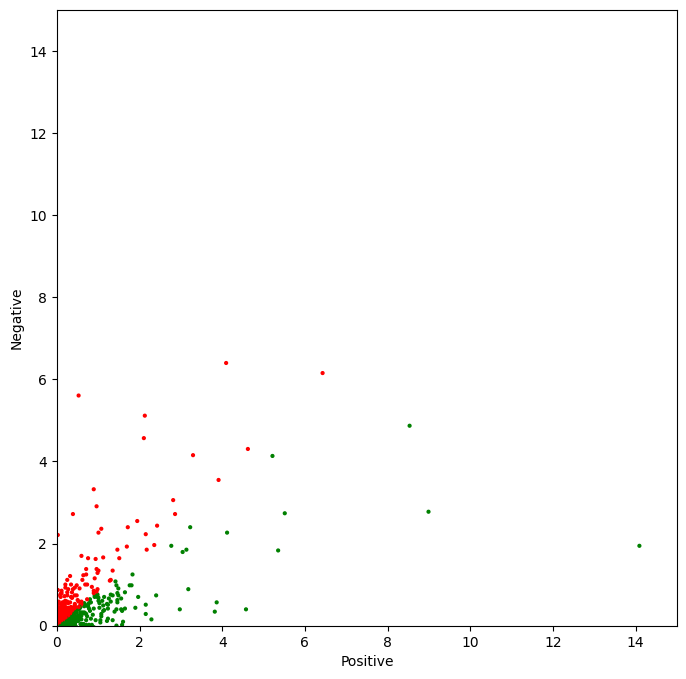

In [267]:
# Plot the samples using columns 1 and 2 of the matrix
fig, ax = plt.subplots(figsize = (8, 8))

colors = ['red', 'green']

# Color based on the sentiment Y
ax.scatter(X[:,1], X[:,2], c=[colors[int(k)] for k in Y], s = 4)  # Plot a dot for each pair of words
plt.xlabel("Positive")
plt.ylabel("Negative")
plt.ylim([0,15])
plt.xlim([0,15])

##### From the plot, it is evident that the features chosen to represent tweets as numerical vectors allows an almost perfect separation between positive and negative tweets. Thus, the accuracy is that high.

![Alt text](../figures/theta_calculus.png)

In [260]:
theta = model.coef_[0].tolist()
# Equation for the separation plane
# It give a value in the negative axe as a function of a positive value
# f(pos, neg, W) = w0 + w1 * pos + w2 * neg = 0
# s(pos, W) = (-w0 - w1 * pos) / w2
def neg(theta, pos):
    return (-theta[0] - pos * theta[1]) / theta[2]

# Equation for the direction of the sentiments change
# We don't care about the magnitude of the change. We are only interested 
# in the direction. So this direction is just a perpendicular function to the 
# separation plane
# df(pos, W) = pos * w2 / w1
def direction(theta, pos):
    return    pos * theta[2] / theta[1]

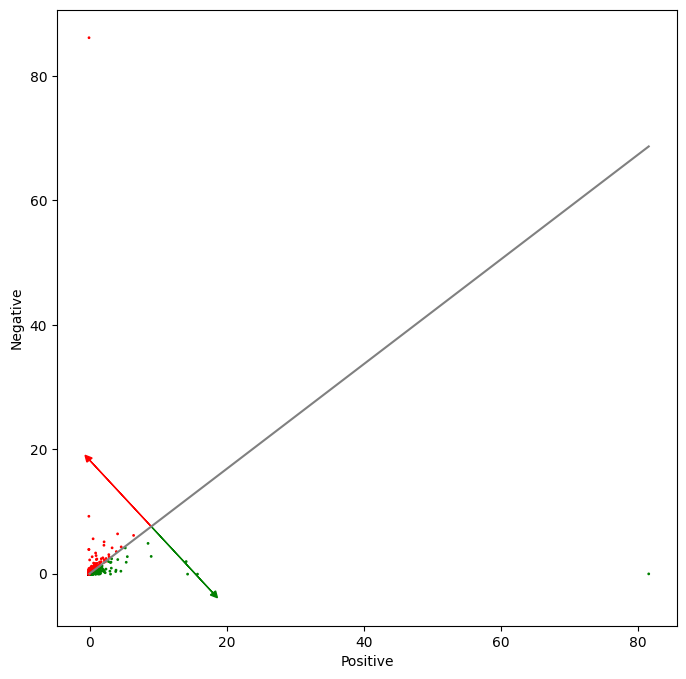

In [265]:
# Plot the samples using columns 1 and 2 of the matrix
fig, ax = plt.subplots(figsize = (8, 8))

colors = ['red', 'green']

# Color base on the sentiment Y
ax.scatter(X[:,1], X[:,2], c=[colors[int(k)] for k in Y], s = 1)  # Plot a dot for each pair of words
plt.xlabel("Positive")
plt.ylabel("Negative")

# Now lets represent the logistic regression model in this chart. 
maxpos = np.max(X[:,1])

offset = 9 # The pos value for the direction vectors origin

# Plot a gray line that divides the 2 areas.
ax.plot([0,  maxpos], [neg(theta, 0),   neg(theta, maxpos)], color = 'gray') 

# Plot a green line pointing to the positive direction
ax.arrow(offset, neg(theta, offset), offset, direction(theta, offset), head_width=1, head_length=1, fc='g', ec='g')
# Plot a red line pointing to the negative direction
ax.arrow(offset, neg(theta, offset), -offset, -direction(theta, offset), head_width=1, head_length=1, fc='r', ec='r')


In [259]:
theta[0].tolist()

[0.0, 153.24980808089978, -181.8995092378139]

## Cost Function

- It deepends on Theta and X_i.
- The first component:
- - Sum over the variable m ( m = number of training samples ).
- - We are going to sum over the cost of all training samples.
- - The component: - (1 / m)
- - - Indicates that when combined with the sum, this will be some kind of average. 
- - - Minus sign, since we are taking log() of a value between 0 and 1. This returns a negative number. So it balances it.
-
- Then, Inside the brackets, te equation has 2 terms that are added together, each one is important for one label.
- 
- 1. Product of y_i (label for each training sample) with the log( predicted value ).
- - Important term, when y_i, the observed label, is 1. Are we predicting similar to 1 in this case?
- - - if y_i = 1, and prediction = 0.99. The product would be 0. Since the log(0.99) is barely zero. 
- - - if y_i = 0, and prediction = any. Product = 0. Since, 0 * any = 0.
- - - if y_i = 1, and prediction = 0. Product = - Inf. Since log(0) = -Inf.
- - When label = 1, and prediction is close to 1, the term approaches 0. Cost Function very low value.
-
2. Product of 1 - y_i with log(1 - predicted value ).
- - Important term, when y_i = 0. Since (1-1) would be 0.
- - - if y_i = 0, and prediction = 0. Product = 0. Since log(1) = 0. 1*0 = 0.
- - - if y_i = 1, and prediction = ANY. The product = 0. Since 1-1 * 0 = 0. 
- - - if y_i = 0, and prediction = 0.99. Product = -Inf.

![Alt text](../figures/loss_logistic.png)

- In both cases, when label and prediction are similar, the loss is close to 0.